In [203]:
import numpy as np 
import math
import peakutils
import numpy.fft as fft
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from matplotlib import cm  
import scipy.integrate 
import scipy.signal as signal 
import pandas as pd
from scipy.stats import sem

import pickle 
import random as rand  
from numpy import random

from sklearn import decomposition 
from deap import creator, base, tools, algorithms 
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans  
import os.path 


# <font color='yellow'>The class belows has the cost function and ODEs, as well as the plotting function</font>


### <font color = 'gree'>Visualizing Raw Data</font>

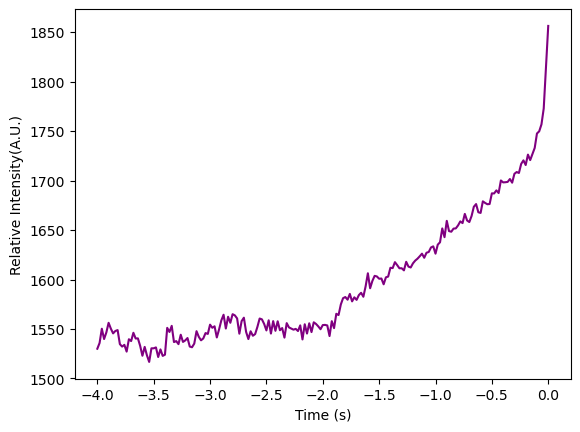

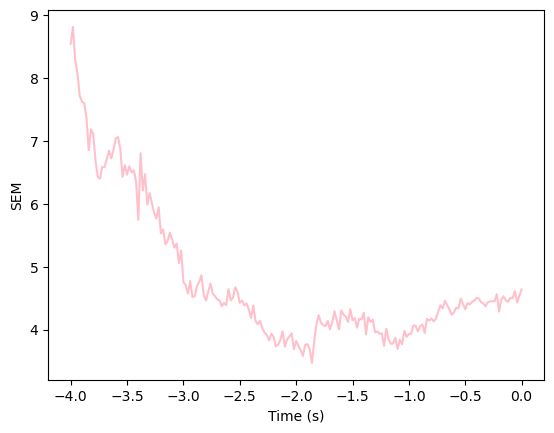

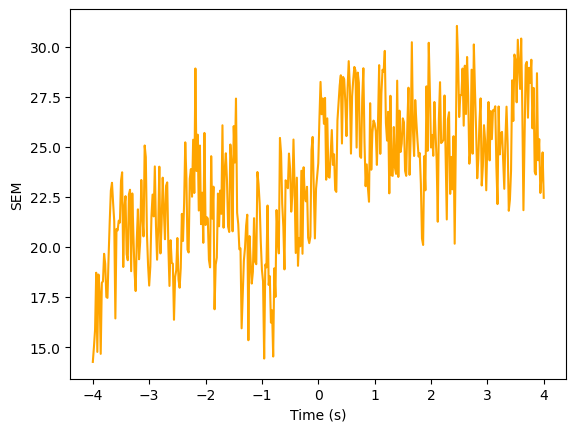

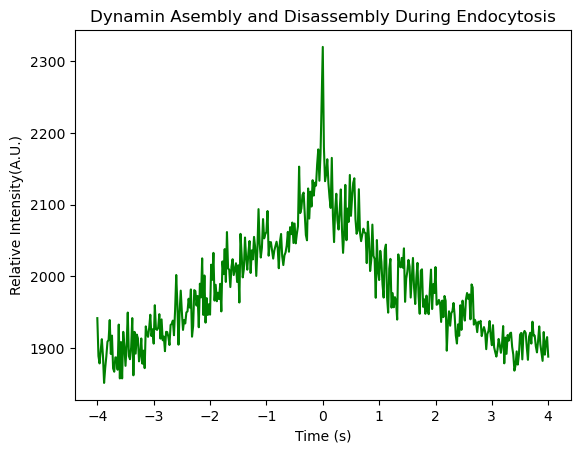

In [204]:
DATA = pd.read_table("/Users/cmdb/Desktop/JOHNSON_rotation/dynamin_model/PythonCode/RAWDATA/expdataBB_from4.dat", header=None,sep=r"\s+",names=['time','expInt','expSEM'])
#print(DATA[0:5])

x = DATA['time']
y = DATA['expInt']
y_WHAT = DATA['expSEM']


plt.plot(x, y, color = 'purple')

plt.xlabel("Time (s)")
plt.ylabel("Relative Intensity(A.U.)")
plt.show()

plt.plot(x, y_WHAT, color = 'pink')

plt.xlabel("Time (s)")
plt.ylabel("SEM")
plt.show()

DATA_new = pd.read_table("/Users/cmdb/Desktop/JOHNSON_rotation/dynamin_model/PythonCode/RAWDATA/Dynamin1AB_kinetics_RawData.csv", header=None,sep=',',names=['time','expInt', 'expSEM'])
DATA_new_filtered = DATA_new[(DATA_new['time'] >= -4.00) & (DATA_new['time'] <= 0)]

#print(DATA_new_filtered[0:5])

DATA_4to4 = DATA_new[(DATA_new['time'] >= -4.00) & (DATA_new['time'] <= 4)]

x_new = DATA_4to4['time']
y_new = DATA_4to4['expInt']


y_SEM= DATA_4to4['expSEM']

plt.plot(x_new, y_SEM, color = 'orange')

plt.xlabel("Time (s)")
plt.ylabel("SEM")
plt.show()



plt.plot(x_new, y_new, color = 'green')

plt.xlabel("Time (s)")
plt.ylabel("Relative Intensity(A.U.)")
plt.title("Dynamin Asembly and Disassembly During Endocytosis")
#plt.savefig('dynamin_raw_fluorescence.png', dpi=900)
plt.show()


In [205]:
## Re-indexing due to error in class Oscillator
# print(DATA_new_filtered)

# new_index = range(len(DATA_new_filtered))
# df_reindexed = DATA_new_filtered.set_index(pd.Index(new_index))
# print(df_reindexed)

In [261]:
'''
The deterministic model of biological oscillator
''' 
class Oscillator: 
	
	def __init__(self, parameter_ranges, params, Dsol0, Dmem0, GTPconc, isoform, mode = 0): 
		#parameter_ranges and params will only include those PARAMETERS that will be UNDER OPTIMIZATION
		self.nParams = len(params)   
		self.paramsToOpt = params #model parameters to be optimized
		self.parameter_ranges = parameter_ranges #allowed parameter ranges  
		self.tMax = 8.5
		
		#3D to 2D lengthscale in um
		self.h = 0.01
		VAratio=1.91
		print('Modeling isoform: '+ isoform)
        #Define System geometry: A in um2, V in um3
		if isoform=='AB':
			self.Atotal=4.34
			self.Acluster=0.023
			self.V=self.Atotal*VAratio
        #Dimensionality factor, should be the same in dense and dilute
			self.gamma = self.V/(self.Atotal*self.h)
        #define system geometry for the dense clusters.
			self.AtotalDense=0.57
			self.AclusterDense=0.026
			self.VDense=self.AtotalDense*VAratio 
		#Dimensionality factor, should be same in dense and dilute
			self.gammaDense = self.VDense/(self.AtotalDense*self.h)                
			self.densIncrease = 7 #factor increase in density on the membrane
			targetIncrease=45 #how much should intensity increase 
			targetIncreasePost=14 #how much should intensity increase  
			print("AB isoform is GOINGGGGGG!")              
		
            
		self.Dsol0 = Dsol0 #initial dynamin conc.
		self.Dmem0 = Dmem0 #initial dynamin mem copies/um2
		self.GTPconc = GTPconc
		expDt=0.02 
		nTimePoints=int(self.tMax/expDt)
		self.timePoints=[i*expDt for i in range(nTimePoints)] 
		self.expdata_unfiltered = pd.read_table("/Users/cmdb/Desktop/JOHNSON_rotation/dynamin_model/PythonCode/RAWDATA/Dynamin1AB_kinetics_RawData.csv", header=None,sep=',',names=['time','expInt', 'expSEM'])
		self.expdata_0 = self.expdata_unfiltered[(self.expdata_unfiltered['time'] >= -4.00) & (self.expdata_unfiltered['time'] <= 4)]
		new_index = range(len(self.expdata_0))
		self.expdata = self.expdata_0.set_index(pd.Index(new_index))
		startToZero = 4 
		self.expTime = self.expdata.time + startToZero 


		N=len(self.expdata)
        #make relative intensity higher!
		#self.delIntensity=(self.expdata.expInt[N-1]-targetIncrease*self.expdata.expInt[0])/(1.0-targetIncrease)
		
		self.delIntensity=(np.max(self.expdata.expInt)-targetIncrease*self.expdata.expInt[0])/(1.0-targetIncrease)
		print('delIntensity HAS A VALUE OF: '+str(self.delIntensity))


		# x_values = self.expTime
		# y_values = self.expdata.expInt

		# plt.plot(x_values, y_values, color = 'red')
		# plt.show()
		#adding assert statement for plot
		assert all(y > -40 for y in y_values), "Data did not load correctly!"
		print("Data loaded correctly")

		self.mode = mode    
        
		self.modes = [self.evaluate_parms]    
		self.threshold = -500000  

		
	def costChi_pre(self, Y): 
		#Define relative intensity that is compared to the experimental data
		relInt=(self.expdata.expInt-self.delIntensity)/(self.expdata.expInt[0]-self.delIntensity)
		sem=self.expdata.expSEM/(self.expdata.expInt[0]-self.delIntensity)
		copies=Y*self.V*602
		c=copies[3]/self.Atotal #Rdilute
		ac=copies[1]/self.Atotal #Ddilute
		acd=copies[4]/self.Acluster #Dclus2D
		ad=copies[5]/self.Acluster #Dclus3D
        #2D vs 3D recruitment growth
      
		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point

        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac), ac[0])
		nPt=len(relInt)
		nPsol=len(acd)
		if(nPsol<nPt):
			cost=self.threshold*2
			print(nPsol)
			print("too few points in solution") 
			print(nPsol)
			print("need: "+str(nPt)+ " points.")
		else:
			sum=0
			for i in range(nPt):
				df=relInt[i]-intensRatio[i]
				sum=sum+df*df/(sem[i]*sem[i]) 
			cost=-sum
		return [cost]
    
		
	def isViableFitness(self, fit):
        #the cost function is to be maximized, greater than some threshold
		return fit >= self.threshold
		
	def isViable(self, point): 
		fitness = self.evaluate_parms(point)  
		
		return self.isViableFitness(fitness[0]) #don't need zero index if 1D
		
	#evaluates a candidate  
	def evaluate_parms(self, candidate): 
		[solutionPre]=self.simulate(candidate) 
		Ypre = np.array(solutionPre) 
		copies=Ypre*self.V*602
		c=copies[3]/self.Atotal #Rdilute
		ac=copies[1]/self.Atotal #Ddilute
		acd=copies[4]/self.Acluster #Dclus2D
		ad=copies[5]/self.Acluster #Dclus3D
        #2D vs 3D recruitment growth

		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point

		chiPre=self.costChi_pre(Ypre)
		return [chiPre, twoDvs3D[0]]

        
#simulate a candidate pre-stimulation
	def simulate_pre(self, candidate):
		
		# Values to convert to 3D units 
		DmemDens=self.Dmem0 #units of /um2
		GTPconc = self.GTPconc
		RclusDens=DmemDens/candidate[3]  #5 is targetDensRatio
		RdiluteDens = candidate[1]

		# Input species concentrations
        #convert all densities to uM units
		Dsol0=self.Dsol0 #units of uM: this is equilibrium pre-activation
		Dmem0=DmemDens*self.Atotal/self.V/602.0 
		# DynTotal=Dsol0+Dmem0 #units of uM        
		Rclus0=RclusDens*self.Acluster/self.V/602.0
		Rdilute0=RdiluteDens*self.Atotal/self.V/602.0
		D2Dclus = 0
		Dclus = 0
		Dclus_hydro = 0
		initValues=np.array([Dsol0,Dmem0,Rclus0,Rdilute0,D2Dclus, Dclus, GTPconc, Dclus_hydro])

        # rate constants for model (s^-1)
		kfDRC=candidate[0] #binding to cluster activator, irreversible
		kfDRD=candidate[4] #binding to dilute recruiter is reversible
		kfDydy=kfDRC*candidate[2] #4 is targetRateRatio
		kbDRD=Dsol0*Rdilute0/Dmem0*kfDRD;
		#kbDRC=kbDRD
		kfhyd=candidate[5] #hydrolysis reaction of dynamin 
		kfdisMem=candidate[6] #disassembly of dynamin into Dmem and Dsol
		kfdisSol=candidate[7]
		rateParams=np.array([kfDRC, kfDRD, kbDRD, self.gamma, kfDydy, kfhyd, kfdisMem, kfdisSol])
		
        #Solve the ODE from 0 to tMax (8.5 seconds)
		solution = scipy.integrate.solve_ivp(fun=self.dynaminODE,method='Radau', t_span=(0, self.tMax), y0=initValues, t_eval=self.timePoints, args=(rateParams,), rtol=1e-7, atol=1e-9)
		return solution.y

	#simulates a candidate
	def simulate(self, candidate):
        #simulate the prestimulation model
		solutionPre=self.simulate_pre(candidate)
        #simulate the post-stimulation model
		# solutionPost=self.simulate_post(candidate)
		return [solutionPre] # solutionPost]

    
	def plotModel(self, solutions, file = None, mode  = None, show = True, showConc = False):     		
		t = self.timePoints
		#print("ALL TIME POINTS" + str(t))
		fig = plt.figure(figsize=(8,4),dpi=900)

		expInt = np.copy(self.expdata.expInt)
		delIntensity = np.copy(self.delIntensity)
		time_model = np.copy(self.timePoints)
		time_exp = np.copy(self.expTime)

		relInt= (expInt-delIntensity)/(expInt[0]-delIntensity)
		
		if mode == "ode":
			[solutionPre] = self.simulate(solutions)
			copies = solutionPre*self.V*602
		else:
			copies = solutions*self.V*602

		c=copies[3]/self.Atotal #Rdilute
		ac=copies[1]/self.Atotal #Ddilute
		acd=copies[4]/self.Acluster #Dclus2D
		ad=copies[5]/self.Acluster #Dclus3D

        #2D vs 3D recruitment growth
		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point
       
        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac), ac[0])
		plt.plot(time_model, intensRatio, color="grey", label='Model')
		plt.plot(time_exp, relInt, color="green",label="Experiment")

		# Adding chi-sqared value to the plot
		#chi_squared_value = self.costChi_pre(solutionPre)[0]
		#plt.text(0.05, 0.95, fr'$\chi^2$ = {chi_squared_value}', transform=plt.gca().transAxes, fontsize=8, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

		plt.xlabel('Time (s)')
		plt.ylabel('Relative Intensity (A.U.)')
		plt.legend(loc = 'upper right', prop={'size': 6})
		plt.show()

		# Concentrations for time series plot
		Dsol=solutions[0]
		#print("DSOL CONCENTRATION AT ALL TIME POINTS"+ str(Dsol))
		Dmem = solutions[1]
		#Dclus = solutions[5]
		GTPconc = solutions[6]
		Dclus_hydro = solutions[7]
		
		if showConc == True:
			plt.plot(t,Dsol, color="magenta", label = 'Dsol uM')
			plt.plot(t,Dmem, color = "green", label = "Dmem uM")
			plt.plot(t,GTPconc, color = "red", label = "[GTP] uM")
			plt.plot(t,Dclus_hydro, color = "blue", label = "Dclus_hydro uM")

			plt.xlabel('Time (s)')
			plt.ylabel('Concentration (uM)')
			
			# plt.ylim(-1,10)
			##plt.ylim(top=110, bottom = -10)
			plt.legend(loc = 'upper right', prop={'size': 6})
			plt.show()


		if file is not None:
			f1 = open(str(file), "w")
			dfs = pd.DataFrame([self.timePoints, intensRatio, twoDvs3D]).T
			dfs.to_csv(f1, sep='\t', header=["time", "intensRatio", "twoDvs3d"])


	def dynaminODE(self, t, y, rateParams): 
		# Rate constants
		kfDRC=rateParams[0] #rate binding to activator in cluster, irreversible
		kfDRD=rateParams[1] #rate binding to dilute recruiter from solution
		
		#kbDRC=rateParams[2] #rate of UNbinding from WHAT??? Never used in expressions below.....
		#kbDRC = kbDRD throughout the rest of the script, it is called in simulate_pre, but not here

		kbDRD=rateParams[2] #rate of UNbinding from dilute recruiter
		gamma=rateParams[3] #a demensionality factor taking into account the volume and area of the system
		kfDydy=rateParams[4] #rate constant for dynamin-to-dynamin assembly
		# new parameters for disassembly
		kfhyd=rateParams[5] #rate of hydrolysis of final dynamin helix
		kfdisMem=rateParams[6] #rate of disassebly from helix to membrane-bound dynamin
		kfdisSol=rateParams[7] #rate of disassembly from helix to membrane-bound dynamin

		# Species ("initValues" called in simulate_pre)
		Dsol0 = y[0]
		Dmem0 = y[1]
		Rclus0 = y[2] #Aclus in paper
		Rdilute0 = y[3] #Rmem in paper
		D2Dclus = y[4]
		Dclus = y[5]
		GTPconc = y[6]
		Dclus_hydro = y[7]

		# 1st order rate xpressions 
		bind3DtoCluster = kfDRC*Dsol0*Rclus0 #rate of dynamin binding to the cluster from solution (3D)
		bind2DtoCluster = kfDRC*gamma*Dmem0*Rclus0 #rate of dynamin binding to the cluster from 2D
		bind3DtoDilute = kfDRD*Dsol0*Rdilute0 #rate of dynamin binding to recruiter (not in cluster) from solution (3D)
		bind2DtoDyn = kfDydy*gamma*Dmem0*D2Dclus #rate of dynamin on membrane binding to dynamin in cluster formed from 2D
		bind2Dto3DDyn = kfDydy*gamma*Dmem0*Dclus #rate of dynamin on membrane binding to dynamin custer formed from 3D
		bind3DtoDyn = kfDydy*Dsol0*D2Dclus #rate of dynamin binding to 3D dynamin
		bind3Dto3DDyn = kfDydy*Dsol0*Dclus #rate of dynamin binding to 3D dynamin (cluster bound)

		# New, added expressions for rate of Dclus_hydro
		 #rate of dynamin hydrolysis is dependent on the concentration of GTP 
		creation_Dclus_hydro = kfhyd*(Dclus+D2Dclus)*GTPconc 
		#concentration of dynamin on the membrane after disassembly
		Dclus_hydroDisassemblytoMem = Dclus_hydro*kfdisMem 
		#concentration of dynamin in solution after disassembly
		Dclus_hydroDisassemblytoSol = Dclus_hydro*kfdisSol 
      
		
        #dynamin in solution - Dsol
		Dsol_ODE = -bind3DtoCluster-bind3DtoDilute+kbDRD*Dmem0-bind3DtoDyn-bind3Dto3DDyn
        #dynamin on membrane - Dmem
		Dmem_ODE = -bind2DtoCluster+bind3DtoDilute-kbDRD*Dmem0-bind2DtoDyn-bind2Dto3DDyn
        #recruiter on the cluster membrane - Aclus
		Aclus_ODE = -bind3DtoCluster - bind2DtoCluster
        #recruiter on the membrane dilute - Rmem
		Rmem_ODE = -bind3DtoDilute+kbDRD*Dmem0
        #Dynamin in cluster from 2D  - D2dclus
		D2dclus_ODE = bind2DtoCluster+bind2DtoDyn+bind2Dto3DDyn
        #Dynamin in cluster from 3D - Dclus
		Dclus_ODE = bind3DtoCluster + bind3DtoDyn+bind3Dto3DDyn

		#Decay in GTP concentration - Dclus_hydro
		GTPconc_ODE = -creation_Dclus_hydro 

		#Hydrolyzed dynamin, can now disassemble
		Dclus_hydro_ODE = creation_Dclus_hydro - Dclus_hydroDisassemblytoMem - Dclus_hydroDisassemblytoSol
		
		dydt=np.array([Dsol_ODE, Dmem_ODE, Aclus_ODE, Rmem_ODE, D2dclus_ODE, Dclus_ODE, GTPconc_ODE, Dclus_hydro_ODE])
		return(dydt)


In [262]:
#CHECKING TO MAKE SURE DATA IS BEING LOADED IN CORRECTLY 
# expdata_unfiltered = pd.read_table("/Users/cmdb/Desktop/JOHNSON_rotation/dynamin_model/PythonCode/RAWDATA/Dynamin1AB_kinetics_RawData.csv", header=None,sep=',',names=['time','expInt', 'expSEM'])
# expdata_0 = expdata_unfiltered[(expdata_unfiltered['time'] >= -4.00) & (expdata_unfiltered['time'] <= 4)]
# new_index = range(len(expdata_0))
# expdata = expdata_0.set_index(pd.Index(new_index))
# startToZero = 4 
# expTime = expdata.time + startToZero 


# targetIncrease = 45
# N=len(expdata)
# #make relative intensity higher!
# delIntensity=(expdata.expInt[N-1]-targetIncrease*expdata.expInt[0])/(1.0-targetIncrease) # dividing by a negative value
# print('delIntensity: '+str(delIntensity))


# x_values = expTime
# y_values = expdata.expInt

# plt.plot(x_values, y_values, color = 'red')
# plt.show()

# #adding assert statement for plot
# assert all(y > -40 for y in y_values), "Error: Y-value less than or equal to -40 found in the plot"


![Alt text](image-3.png)

# <font color='yellow'>Solver runs the genetic algorithm (you'll see in init, uses package called DEAP for genetic operations)</font>

# <font color='pink'>
A parameter is a single rate constant or concentration of macromolecule (dynamin)
 - which is a gene!
A genotype is a combination of parameters 
 - a combination of genes - like a chromosome
A phenotype is a single number/solution
 - the chi-squared COST, fitness of the genotype (how well it matches the experimental data)
The population is the collections of all ofthe indivudals (genotypes -> ohenotype) in a geneeration
 - evolution cannot occur on the individual level

How do the operators actually work
 - mutation
 - crossover (mate)
 - selection 

 Operators work on the population level</font>

In [263]:
'''
The main class
'''

class Solver:
	def __init__(self, model, populationSize=3000, NGEN = 3, nsamples = 1e3):                                                      
		self.model = model            
		self.populationSize = populationSize         
		self.NGEN = NGEN  
		self.nsamples = int(nsamples) 	
		self.indpb = 0.75     	
		
		#GA operators
		creator.create("FitnessMax", base.Fitness, weights=(1.0,)) 
		creator.create("Candidate", list, fitness=creator.FitnessMax)  		
		self.toolbox = base.Toolbox()	 
		self.toolbox.register("candidate", self.generateCandidate)  #function to create individuals
		self.toolbox.register("population", tools.initRepeat, list, self.toolbox.candidate)   #function to create a population
		self.toolbox.register("mate", tools.cxTwoPoint) #crossover
		self.toolbox.register("mutate", self.mutateCandidate, indpb=self.indpb, mult=0.5) #mutation
		self.toolbox.register("select", tools.selTournament, tournsize=int(self.populationSize/10)) #selection	
	
	#estimate initial values with GA
	def findNominalValues(self):    	 	
		nominalVals = []   
		fitnessVals = []
		twoDVals = []
		for evalMode in self.model.modes: 
			nominalValsMode = []
			fitnessValsMode = []
			twoDValsMode = []
			self.toolbox.register("evaluate", evalMode)  #creates a function used to evaluate the fitness of individuals in the population
			#initialize new random population
			self.popu = self.toolbox.population(self.populationSize)  	 
			
			for gen in range(self.NGEN):  
				print("Current generation")
				print(gen)
				#generate offsprings with crossover and mutations
				offspring = algorithms.varAnd(self.popu, self.toolbox, cxpb=0.5, mutpb=0.75)  
				#evaluate individuals
				fits = self.toolbox.map(self.toolbox.evaluate, offspring) 
				for fit, ind in zip(fits, offspring):
					[cost, twoD]=self.model.evaluate_parms(ind)  #evalutates the cost (chisquared) of each individual      
					
					if cost[0]>=self.model.threshold and ind not in nominalValsMode:  #appends the individual to the list of "good"
						nominalValsMode.append(ind)
						fitnessValsMode.append(fit[0]) 
						twoDValsMode.append(twoD)  
					ind.fitness.values = fit[0]     
				#roulete wheel selection
				self.popu = self.toolbox.select(offspring, k=len(self.popu))  #selects individuals for the next generation
				
				rando = np.random.randint(0, len(self.popu))
				rdm_ind = self.popu[rando] #randomly selects an individual from the population - debugging purposes
				print(rdm_ind)

				# self.model.plotModelBoth(rdm_ind)
			print("Number of viable points: " + str(len(nominalValsMode))) #number of individuals meeting threshold criterion
			nominalVals.extend(nominalValsMode)     
			fitnessVals.extend(fitnessValsMode)
			twoDVals.extend(twoDValsMode)
		return [nominalVals, fitnessVals, twoDVals]        
		
	#creates an array of random candidates  
	def generateCandidate(self): 
		candidate = []
		for ind in range(self.model.nParams):
			low=self.model.parameter_ranges[self.model.paramsToOpt[ind]]["min"]
			hi=self.model.parameter_ranges[self.model.paramsToOpt[ind]]["max"]
			value=random.uniform(math.log10(low),math.log10(hi))
			candidate.append(pow(10, value))
		return creator.Candidate(candidate) 	
		
	def checkOutAllBounds(self, candidate):
		for idx, val in enumerate(candidate):
			if self.checkOutOfBounds(candidate, idx): 
				return True  
		return False      
				
	def checkOutOfBounds(self, candidate, idx): 
		#if out of bounds return True 
		if candidate[idx] < self.model.parameter_ranges[self.model.paramsToOpt[idx]]["min"] or candidate[idx] > self.model.parameter_ranges[self.model.paramsToOpt[idx]]["max"]: 
			return True
		return False    		
	
	#returns a tuple of mutated candidate	
	def mutateCandidate(self, candidate, indpb, mult): 	
		for idx, val in enumerate(candidate):	
			rnd = random.uniform(0, 1)
			if rnd >= indpb:
				rnd2 = random.uniform(1 - mult, 1 + mult)   
				candidate[idx] = val*rnd2	
				if candidate[idx] < self.model.parameter_ranges[self.model.paramsToOpt[idx]]["min"]: 
					candidate[idx] = self.model.parameter_ranges[self.model.paramsToOpt[idx]]["min"]  
				if candidate[idx] > self.model.parameter_ranges[self.model.paramsToOpt[idx]]["max"]:  
					candidate[idx] = self.model.parameter_ranges[self.model.paramsToOpt[idx]]["max"]    					
		return candidate,     
	
	def getViablePoints(self, points):
		viable = list() 
		#fitVals = []        
		i = 0
		print(" getting Viable points")        
		for point in points:  
			i += 1
			if i % 1000 == 0:
				print(i)     
			
			#check if point is viable
            
			fitness = self.model.evaluate_parms(point) 
			if(fitness[0] >= self.model.threshold):
			#if self.model.isViable(point):
				augPoint=[]
				augPoint.append(fitness)
				for j in range(self.model.nParams):
					augPoint.append(point[j])
				viable.append(augPoint)   		
				#fitVals.append(fitness[0])
		print("shape of viable")
		print(np.shape(viable))
		return viable          
	
       
    #take in a list of candidates and fitnesses, and write a readable file 
	def write_sortedParms(self, viablePoints, viableFitness, twoDVals, fileStr):
    
		file2="optimizedParmsAB_Dsol"+str(fileStr)+".txt"
		f=open(str(file2),"a")

		fitValues=[]
		negFitValues=[]   

		for i in range(len(viableFitness)):
			fitValues.append(viableFitness[i][0])
			negFitValues.append(-viableFitness[i][0])
            
		sortFit=sorted(fitValues, reverse=True) #descending order
		#print(sortFit[len(viableFitness)-1])
		sortPoint1=[]
		sortPoint2=[]
		sortPoint3=[]
		sortPoint4=[]
		sortPoint5 = [] #for new
		
		idSort=np.argsort(negFitValues) 
		#print(idSort)
		for i in range(len(idSort)):
			index=idSort[i]
			#print(viablePoints[int(index)])
			optParms=viablePoints[int(index)]
			curr2D=twoDVals[int(index)]
			#sortPoint.append(optParms)  
  
			kfDRC=optParms[0]
			kfDRD=optParms[4] #binding to dilute and cluster recruiter are coupled
			kfDydy=kfDRC*optParms[2] #candidate[1]
			Dsol0=self.model.Dsol0 #units of uM
			
			#new 
			GTPconc = self.model.GTPconc
			kfhyd = optParms[6]
			kfdisMem = optParms[7]
			kfdisSol = optParms[8]

			DmemDens=self.model.Dmem0
			RclusDens=DmemDens/optParms[3]  
			RdiluteDens = optParms[1]
			kfDense = optParms[5]
            #convert all densities to uM units
			Dmem0=DmemDens*self.model.Atotal/self.model.V/602.0 
			Rclus0=RclusDens*self.model.Acluster/self.model.V/602.0 #Rclus0 is never called....
			Rdilute0=RdiluteDens*self.model.Atotal/self.model.V/602.0
            #rates for model
            #off rates, s-1
			kbDRD=Dsol0*Rdilute0/Dmem0*kfDRD
			kbDRC=kbDRD
			 
			allParms1=np.array([kfDRC, RdiluteDens, Dsol0, DmemDens]) 
			allParms2=np.array([kfDRD, kfDydy, RclusDens, kfDense])  
			allParms3=np.array([kbDRC, kbDRD, self.model.gamma])
			allParms4=np.array([optParms[2], optParms[3], curr2D])
			allParms5=np.array([GTPconc, kfhyd, kfdisMem, kfdisSol])

			sortPoint1.append(allParms1)
			sortPoint2.append(allParms2)
			sortPoint3.append(allParms3)
			sortPoint4.append(allParms4)
			sortPoint5.append(allParms5)
			
			
		df=pd.DataFrame([sortFit, sortPoint1, sortPoint2, sortPoint3, sortPoint4, sortPoint5]).T
		df.to_csv(f, sep='\t',header=["Chi2","kfDRC, RdiluteDens, Dsol0, DmemDens","kfDRD, kfDydy, RclusDens, kfDense", "kbDRC, kbDRD, gamma","rateRatio, densRatio, 2Dvs3D", "GTPconc, kfhyd, kfdisMem, kfdisSol"])
		#plot out the best solution
		print("Best solution from initial sampling")
        #print out the best solution to file
		file3="bestSolution_rateS_"+"_densS_"+"_Cost_"+str(sortFit[0])+".txt"    
		self.model.plotModel(viablePoints[idSort[0]], file = file3, mode = "ode")
		#plot out the worst solution
		print("WORST solution from initial sampling")
		print(sortFit[len(idSort)-1])        
		self.model.plotModel(viablePoints[idSort[len(idSort)-1]], mode = "ode")

	#Main method  
	def run(self, maxDepth=0):    
		#estimate the initial viable set 
		[viablePoints, viableFitness, twoDVals] = self.findNominalValues()
		fname="optimizedParms.txt"
		self.write_sortedParms(viablePoints, viableFitness, twoDVals, fname)
		#print("wrote to file")
		#print("done with Solver run")

# <font color='yellow'>Define parameter ranges and initial conditions</font>

In [264]:
## DEFINE YOUR RANGES FOR THE GA 

parameter_ranges = { 
            #units of uM-1s-1
            "kfDRC": {"min": 0.0001, "max": 1}, 
            "RdiluteDens": {"min": 1, "max": 500},           				        
           # "kbDRC": {"min": 1, "max": 1}, 
           # "kbDRD": {"min": 1, "max":1}, 
          #  "Dsol0": {"min": 0.5, "max": 10}, #uM        
#            "Dmem0": {"min": 10, "max": 10},#[3]
            "targetRateR": {"min": 0.01, "max": 100},
            "targetDensR": {"min": 0.01, "max": 100},
            "kfDRD": {"min": 0.0001, "max": 1},
            #rate to bind activator in the dense phase
            "kfDense": {"min": 0.0001, "max": 1},
            #"Rclus0": {"min": 1, "max": 100}, 
            #"Rdilute0": {"min": 1, "max": 100}, 
            #"V": {"min": 3.53, "max": 3.53},#um3
            #"Atotal": {"min": 1.85, "max": 1.85}, #um2
            #"Acluster": {"min": 0.022, "max": 0.022}, #um2
            "kfhyd": {"min": 0.0001, "max": 1},
            "kfdisMem": {"min": 0.0001, "max": 1},
            "kfdisSol": {"min": 0.0001, "max": 1}
         #   "GTPconc": {"min": 50, "max": 250} #uM
            }   	

 

## INPUT THE LABELS OF THOSE PARAMETERS INTO SECOND ARGUMENT BELOW, INITIAL CONDITIONS IN THE THIRD
#parameter_values, params, initial_conditions,
paramsToOpt=np.array(["kfDRC","RdiluteDens","targetRateR","targetDensR","kfDRD","kfDense", "kfhyd", "kfdisMem", "kfdisSol"])


# <font color='yellow'>Simulate a model given input parameters</font>

Modeling isoform: AB
AB isoform is GOINGGGGGG!
delIntensity HAS A VALUE OF: 1933.0938181818185
Data loaded correctly
ALL TIME POINTS[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7000000000000001, 0.72, 0.74, 0.76, 0.78, 0.8, 0.8200000000000001, 0.84, 0.86, 0.88, 0.9, 0.92, 0.9400000000000001, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 1.1400000000000001, 1.16, 1.18, 1.2, 1.22, 1.24, 1.26, 1.28, 1.3, 1.32, 1.34, 1.36, 1.3800000000000001, 1.4000000000000001, 1.42, 1.44, 1.46, 1.48, 1.5, 1.52, 1.54, 1.56, 1.58, 1.6, 1.62, 1.6400000000000001, 1.6600000000000001, 1.68, 1.7, 1.72, 1.74, 1.76, 1.78, 1.8, 1.82, 1.84, 1.86, 1.8800000000000001, 1.9000000000000001, 1.92, 1.94, 1.96, 1.98, 2.0, 2.02, 2.04, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16, 2.18, 2.2, 2.22, 2.24, 2.2600000000000002, 2.2800000000000002, 2.3000000000000003, 2.32, 2.3

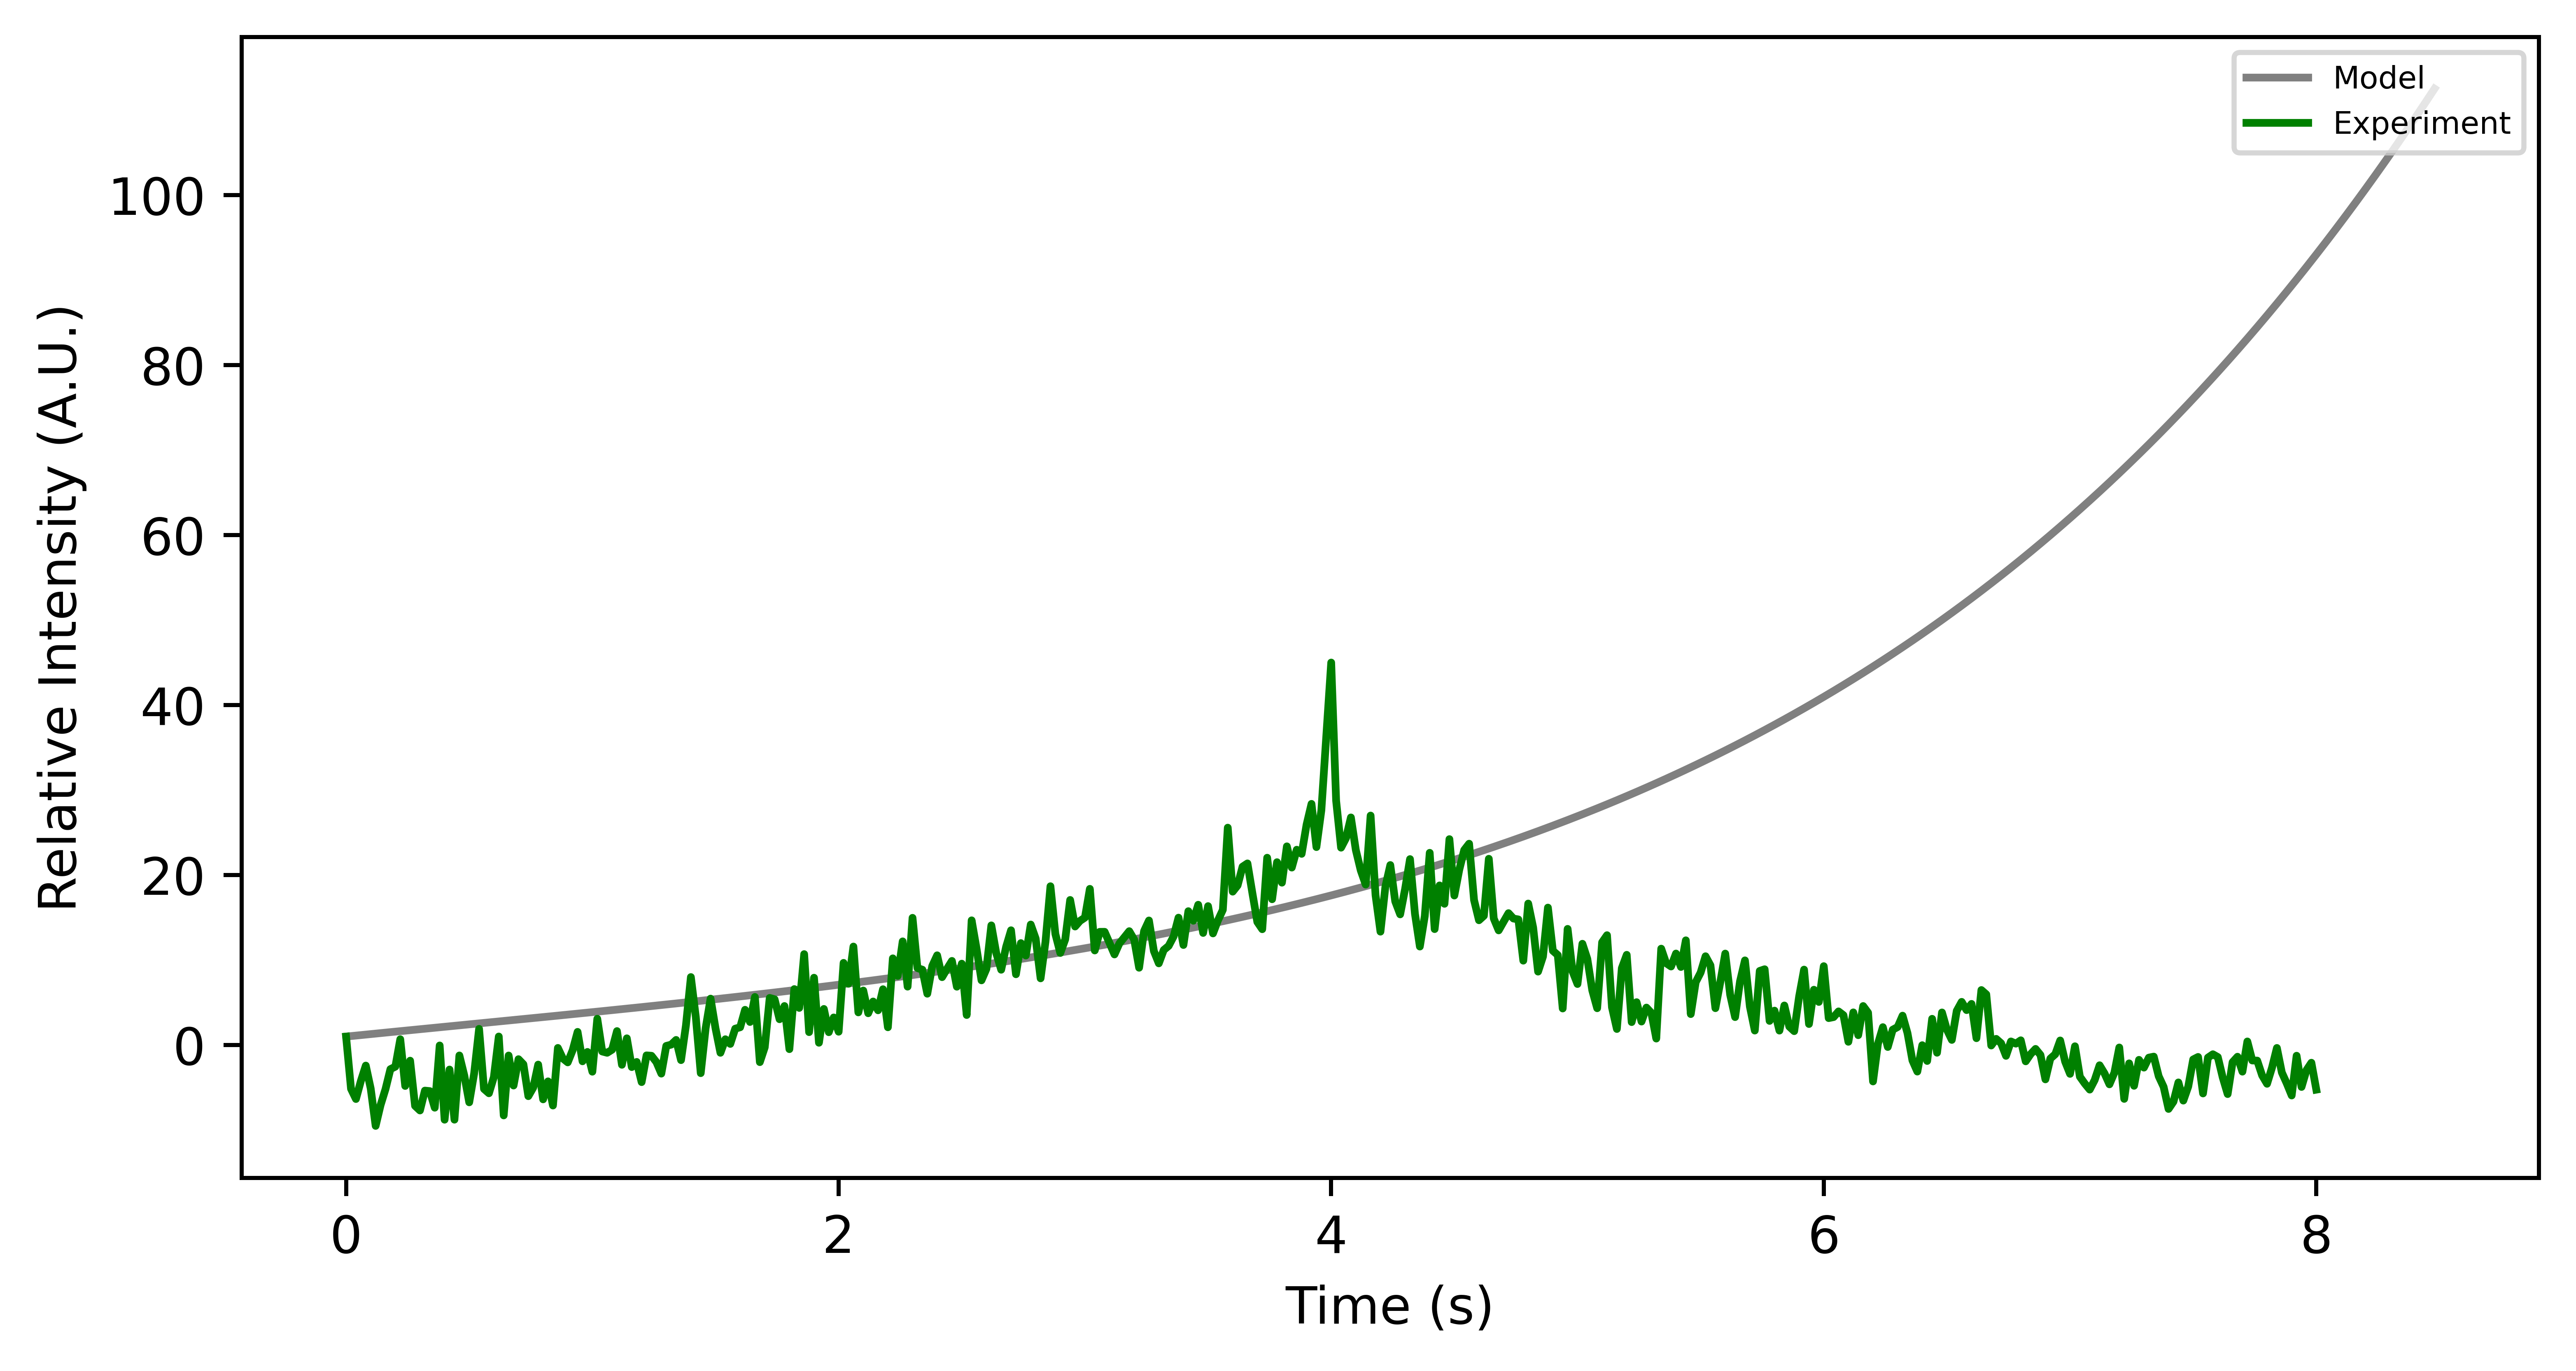

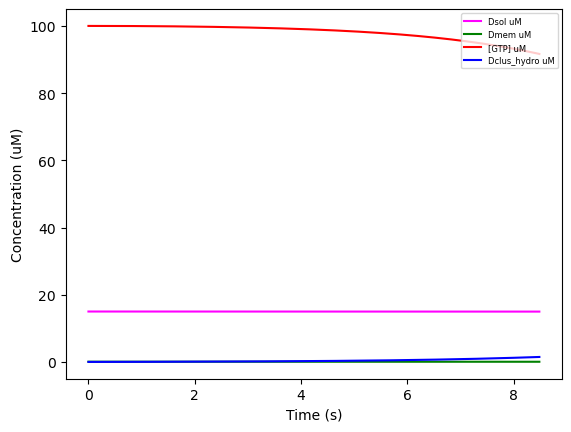

fitness: [-56036.364504013225]


In [265]:
#initialize the model
model = Oscillator(parameter_ranges, paramsToOpt, 15, 74, 100, 'AB', mode=0) #model does not change with changing GTPconc.....
#Dsol0 = 15.43
#Dmem0 = 74
#GTPconc = 100

#define a candidate set of rates
candidate=np.array([2.06515731e-02, 6.55374065e+00, 0.78592423, 0.19185001, 7.01618503e-02, 1, 1, 1])
# removed candidate[5] as it wasn't called anywhere in the script...... 

# kfDRC=candidate[0] 
# RdiluteDens = candidate[1]
# kfDydy=kfDRC*candidate[2] 
# RclusDens=DmemDens/candidate[3]  
# kfDRD=candidate[4] 
# kfhyd=candidate[5] 
# kfdisMem=candidate[6]
# kfdisSol=candidate[7]
# rateParams=np.array([kfDRC, kfDRD, kbDRD, self.gamma, kfDydy, kfhyd, kfdisMem, kfdisSol])	

[solutionPre]=model.simulate(candidate) 
Y = np.array(solutionPre)
model.plotModel(solutionPre, showConc = True)
timePts=model.timePoints
[fitness, twoPre] = model.evaluate_parms(candidate) 
print("fitness: "+ str(fitness))


In [266]:
df=pd.DataFrame([timePts,Y[0],Y[1],Y[2],Y[3],Y[4],Y[5], Y[6], Y[7]]).T
#df.to_csv("concPost_python", sep='\t')

# <font color='yellow'>Use the GA to find a population of solutions over multiple generations</font>

Modeling isoform: AB
AB isoform is GOINGGGGGG!
delIntensity HAS A VALUE OF: 1933.0938181818185
Data loaded correctly
Current generation
0


/Users/cmdb/mambaforge/envs/ODE_solver_JOHNSON/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/cmdb/mambaforge/envs/ODE_solver_JOHNSON/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


[0.03746923417269773, 7.508116349183192, 0.018518019273569143, 0.10602706847630741, 0.44790803312178706, 0.0011647589772352254, 0.5547294610767873, 0.4313587568334651, 0.1875562147363466]
Current generation
1
[0.07071388229347066, 325.06383314059065, 0.010512027481597184, 0.16443114462887026, 0.02187644674193234, 0.029996796370769598, 0.10529317636900291, 0.0010280052247266763, 0.0008511517428544971]
Current generation
2
[0.05758875517250655, 284.1744827096945, 0.010512027481597184, 0.148504443391327, 0.02187644674193234, 0.029996796370769598, 0.015181264002104188, 0.00011525618516424872, 0.22597027661484306]
Current generation
3
[0.05987117859562375, 15.556598963055237, 0.01, 0.15228903475707217, 0.052571410614086884, 0.029996796370769598, 0.2615849312716196, 0.007279363631200762, 0.00022766637937177682]
Number of viable points: 12692
viableFitness[0][0]: -5170.8327765256045
viablePoints[0]: [0.004724418810456624, 11.214285208864752, 0.32368753439400166, 0.3514656711544469, 0.00037318

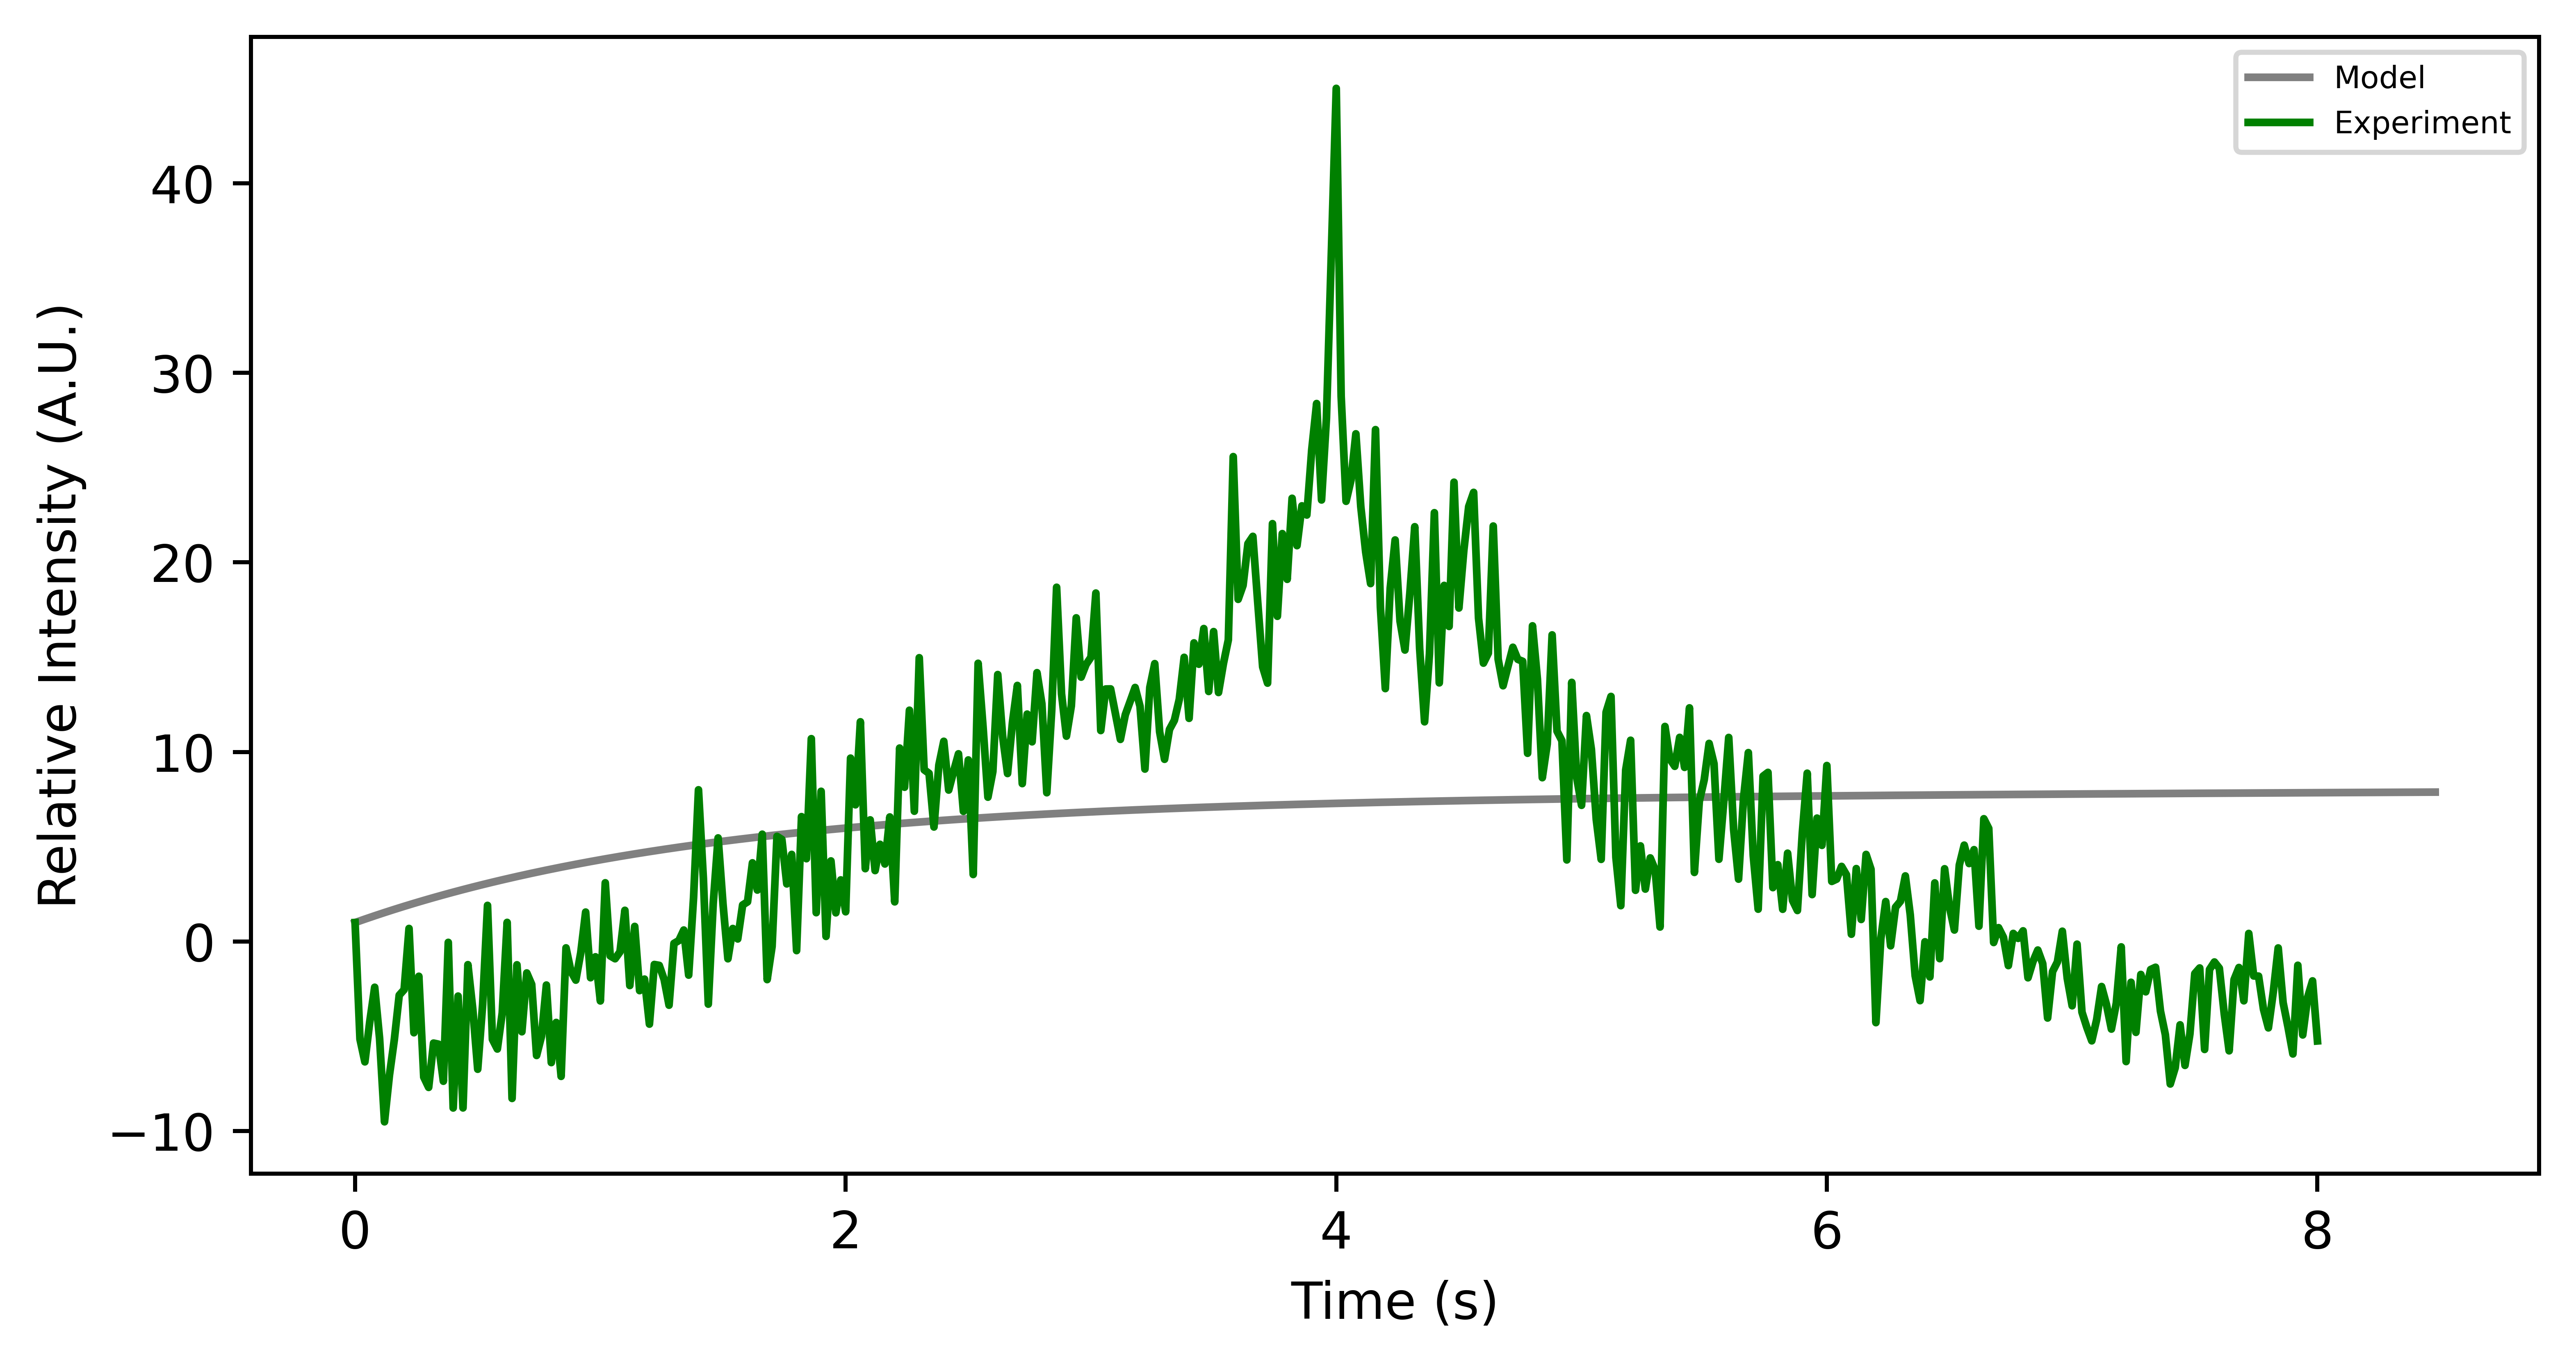

WORST solution from initial sampling
-480202.7993868632
ALL TIME POINTS[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7000000000000001, 0.72, 0.74, 0.76, 0.78, 0.8, 0.8200000000000001, 0.84, 0.86, 0.88, 0.9, 0.92, 0.9400000000000001, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 1.1400000000000001, 1.16, 1.18, 1.2, 1.22, 1.24, 1.26, 1.28, 1.3, 1.32, 1.34, 1.36, 1.3800000000000001, 1.4000000000000001, 1.42, 1.44, 1.46, 1.48, 1.5, 1.52, 1.54, 1.56, 1.58, 1.6, 1.62, 1.6400000000000001, 1.6600000000000001, 1.68, 1.7, 1.72, 1.74, 1.76, 1.78, 1.8, 1.82, 1.84, 1.86, 1.8800000000000001, 1.9000000000000001, 1.92, 1.94, 1.96, 1.98, 2.0, 2.02, 2.04, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16, 2.18, 2.2, 2.22, 2.24, 2.2600000000000002, 2.2800000000000002, 2.3000000000000003, 2.32, 2.34, 2.36, 2.38, 2.4, 2.42, 2.44, 2.46, 2.48, 2.5, 2.52, 2.54, 

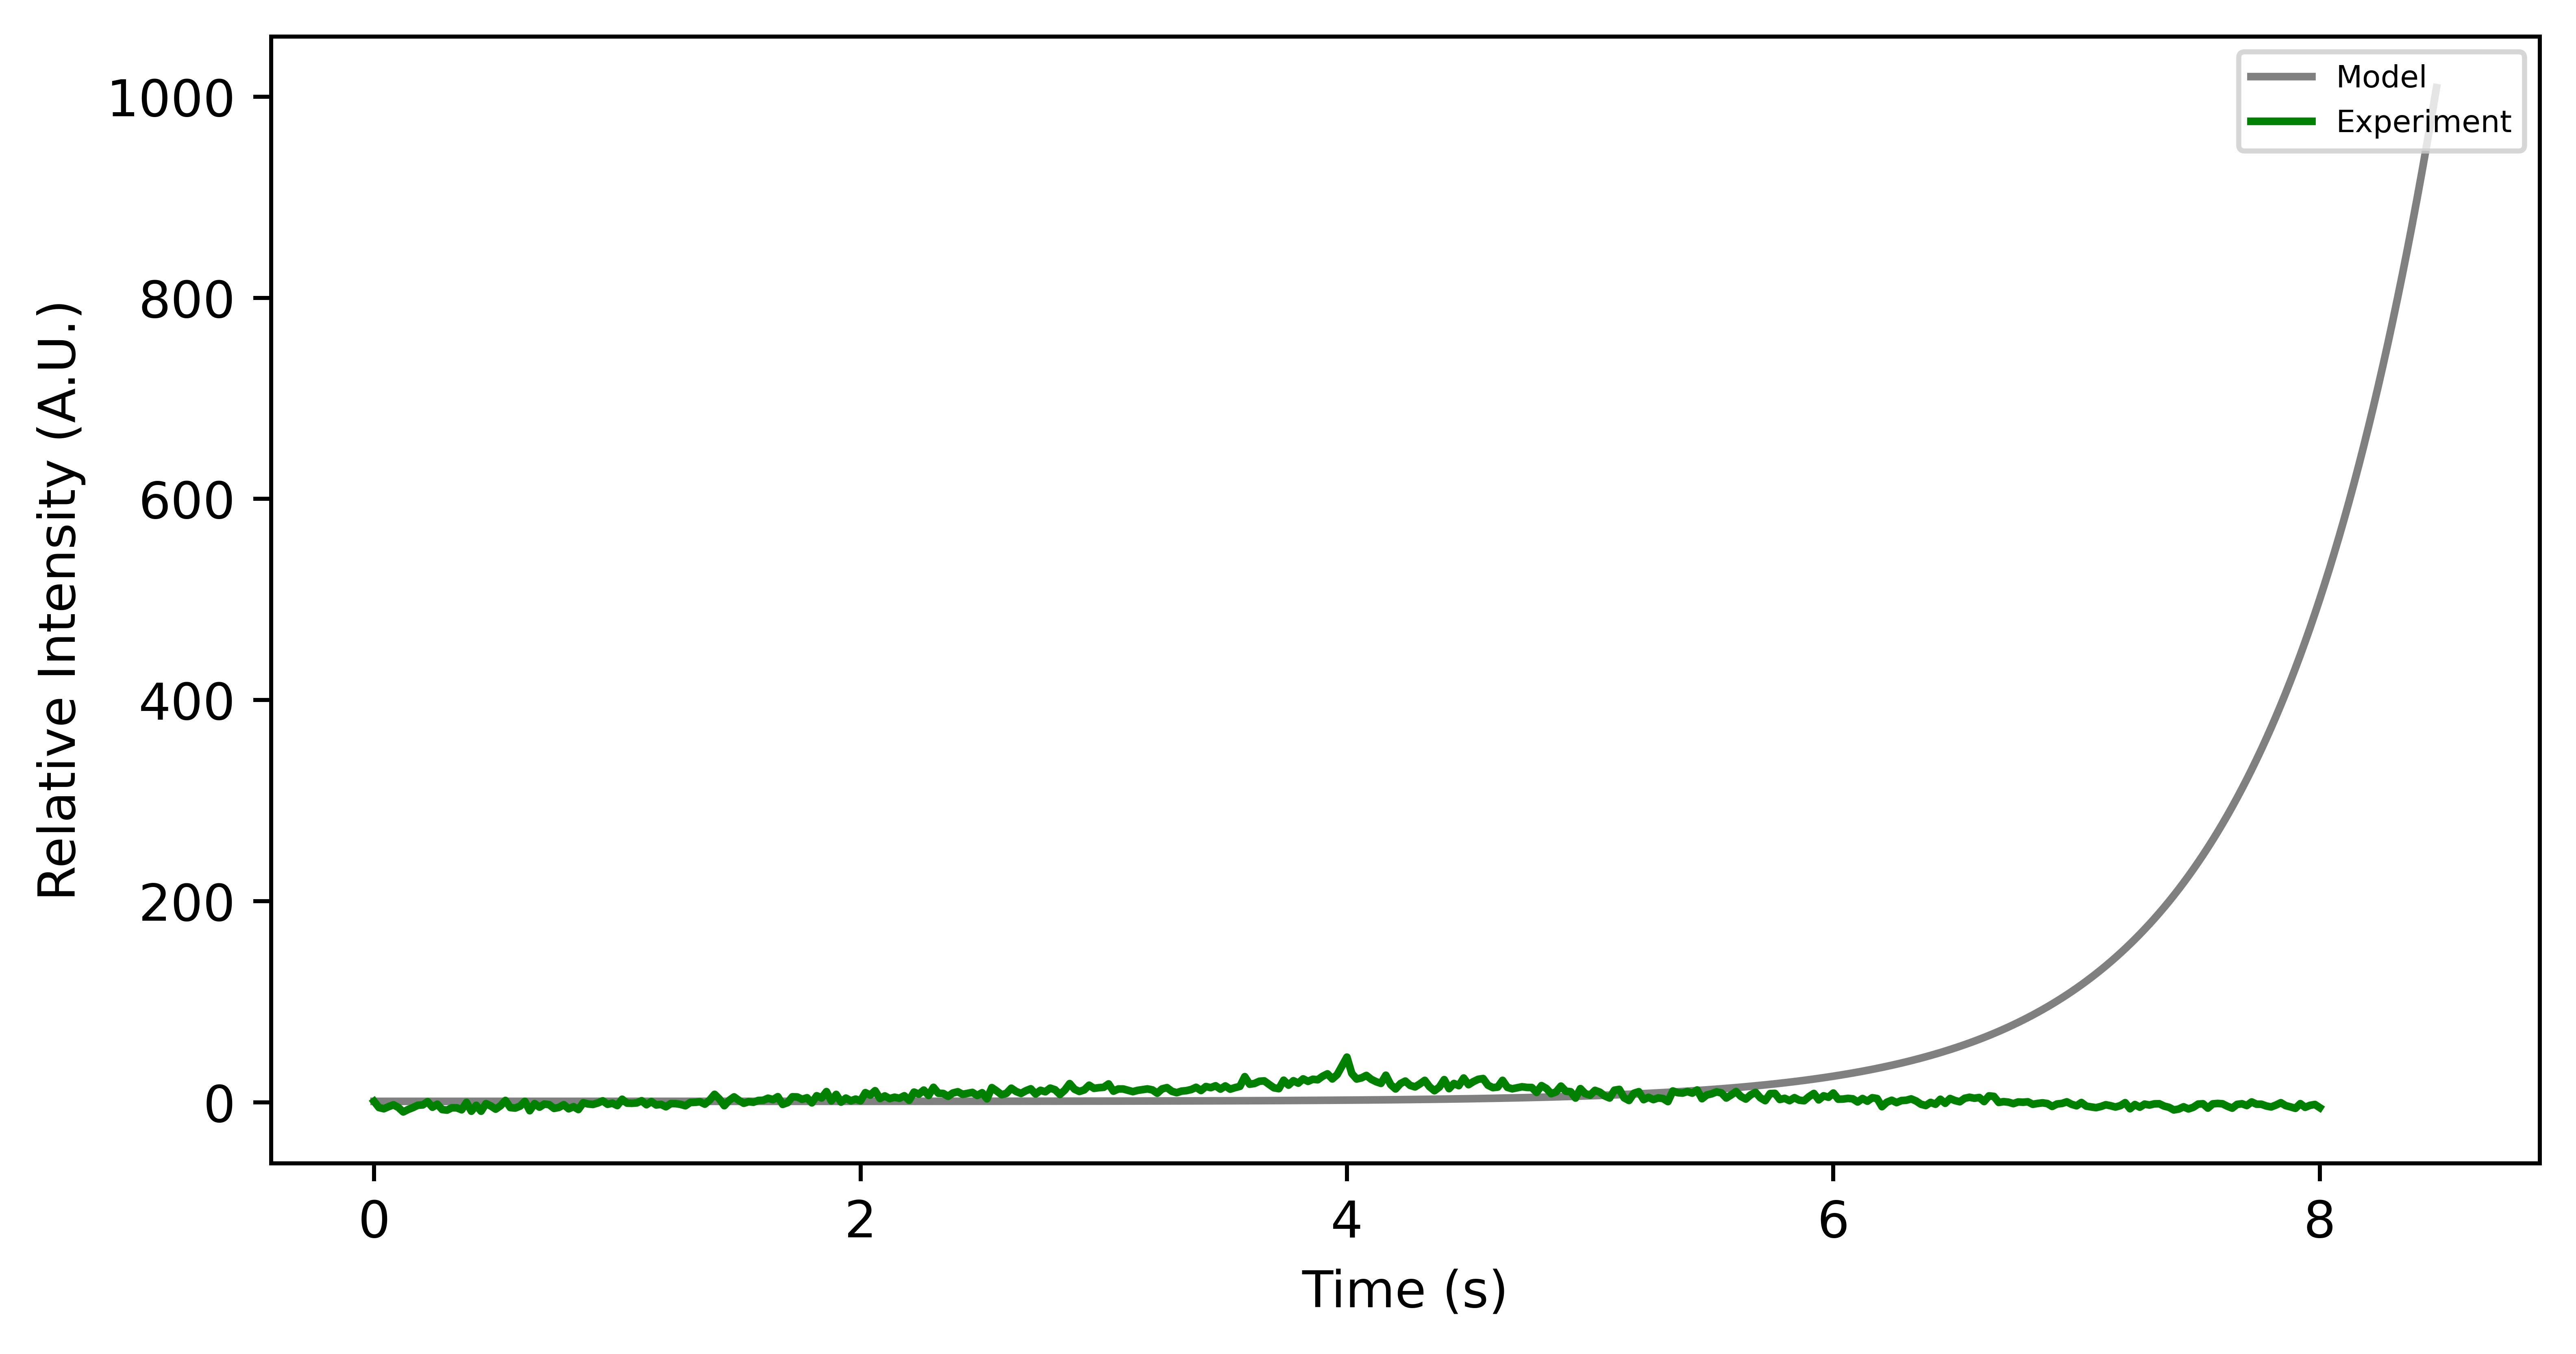

done with all 4 generations for Dsol 50
Modeling isoform: AB
AB isoform is GOINGGGGGG!
delIntensity HAS A VALUE OF: 1933.0938181818185
Data loaded correctly
Current generation
0


/Users/cmdb/mambaforge/envs/ODE_solver_JOHNSON/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/cmdb/mambaforge/envs/ODE_solver_JOHNSON/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


[0.02040189349912819, 1.392637020564626, 0.06296807834302355, 0.09575203081700885, 0.3122008942911281, 0.0026875920130539754, 0.3034639467376403, 0.9123091813352492, 0.042348381005212606]
Current generation
1
[0.06128682042891105, 8.086826752695385, 0.015033546742137291, 0.14878325226781003, 0.001888098346627048, 0.001687502980860324, 0.054763596928049545, 0.0063688975146826065, 0.0017893920860423504]
Current generation
2
[0.06128682042891105, 10.888788788080737, 0.01, 0.15279060755531465, 0.17197349259635894, 0.005366639690745738, 0.021196123112783724, 0.0063688975146826065, 0.0017893920860423504]
Current generation
3
[0.06128682042891105, 13.484602867823146, 0.01, 0.15279060755531465, 0.1052227558881112, 0.005366639690745738, 0.01876921729933063, 0.00807546524079616, 0.0017893920860423504]
Number of viable points: 12322
viableFitness[0][0]: -5429.589300843666
viablePoints[0]: [0.008643706749457455, 122.39250472981378, 0.20718930623024945, 9.030172207784863, 0.2278219286815743, 0.0012

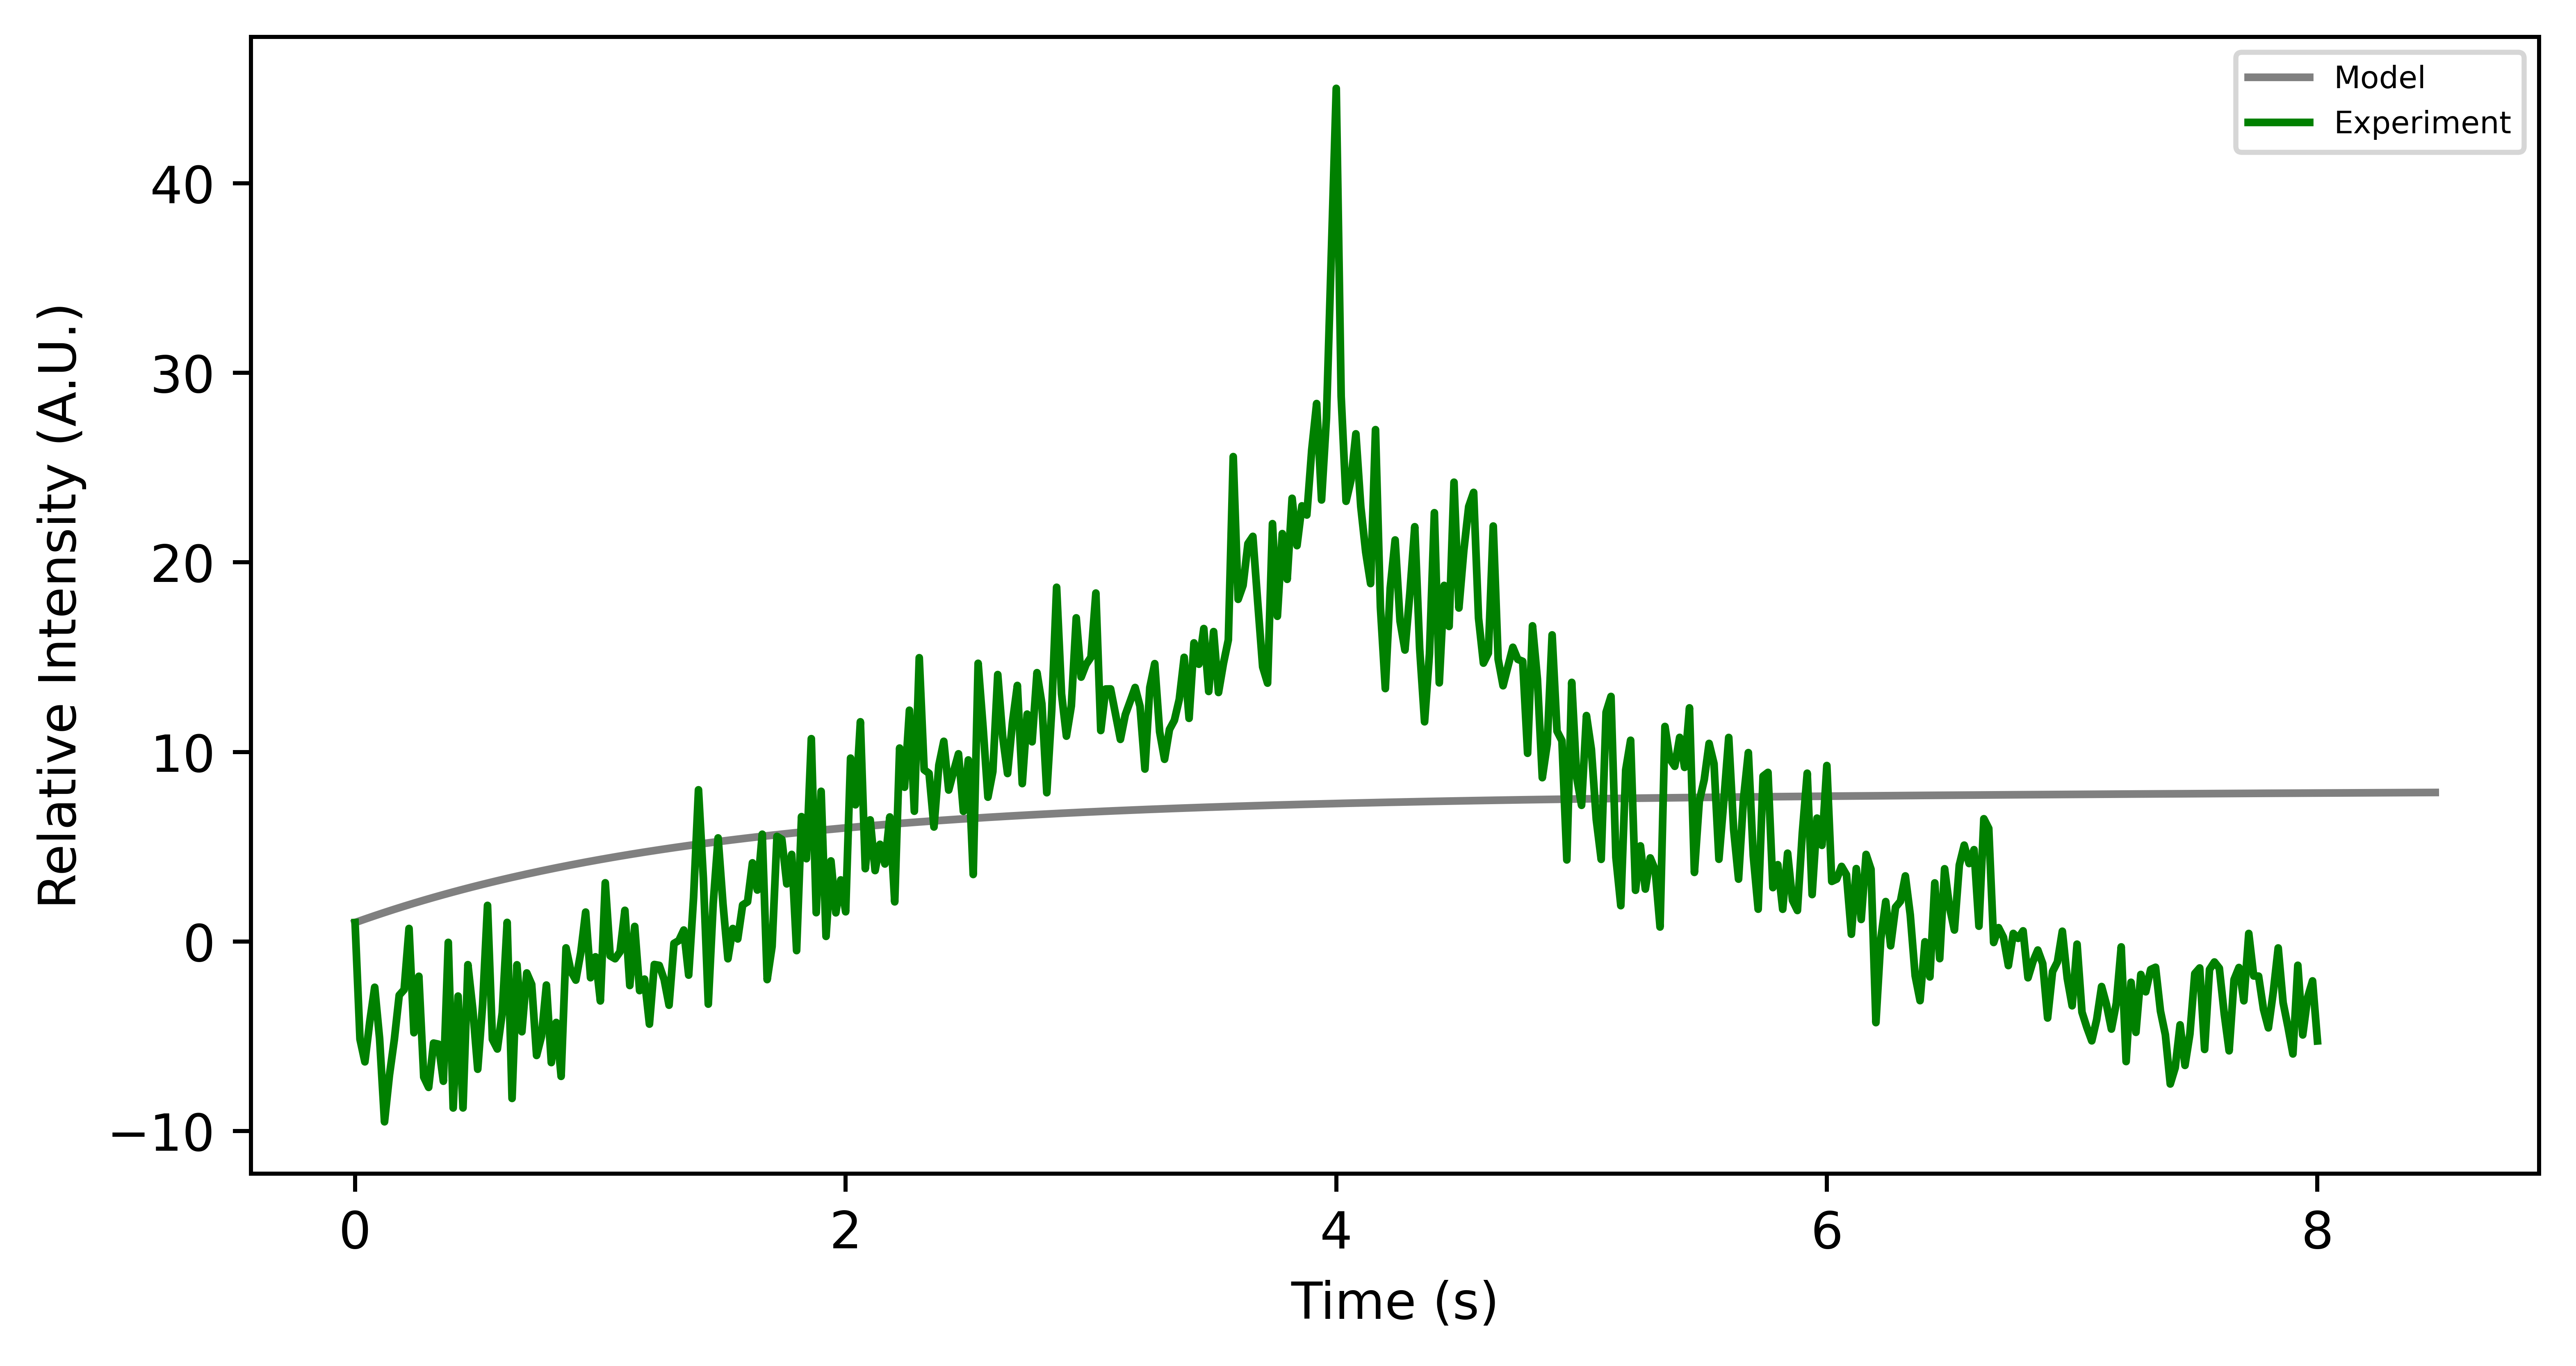

WORST solution from initial sampling
-474783.14727990254
ALL TIME POINTS[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7000000000000001, 0.72, 0.74, 0.76, 0.78, 0.8, 0.8200000000000001, 0.84, 0.86, 0.88, 0.9, 0.92, 0.9400000000000001, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 1.1400000000000001, 1.16, 1.18, 1.2, 1.22, 1.24, 1.26, 1.28, 1.3, 1.32, 1.34, 1.36, 1.3800000000000001, 1.4000000000000001, 1.42, 1.44, 1.46, 1.48, 1.5, 1.52, 1.54, 1.56, 1.58, 1.6, 1.62, 1.6400000000000001, 1.6600000000000001, 1.68, 1.7, 1.72, 1.74, 1.76, 1.78, 1.8, 1.82, 1.84, 1.86, 1.8800000000000001, 1.9000000000000001, 1.92, 1.94, 1.96, 1.98, 2.0, 2.02, 2.04, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16, 2.18, 2.2, 2.22, 2.24, 2.2600000000000002, 2.2800000000000002, 2.3000000000000003, 2.32, 2.34, 2.36, 2.38, 2.4, 2.42, 2.44, 2.46, 2.48, 2.5, 2.52, 2.54,

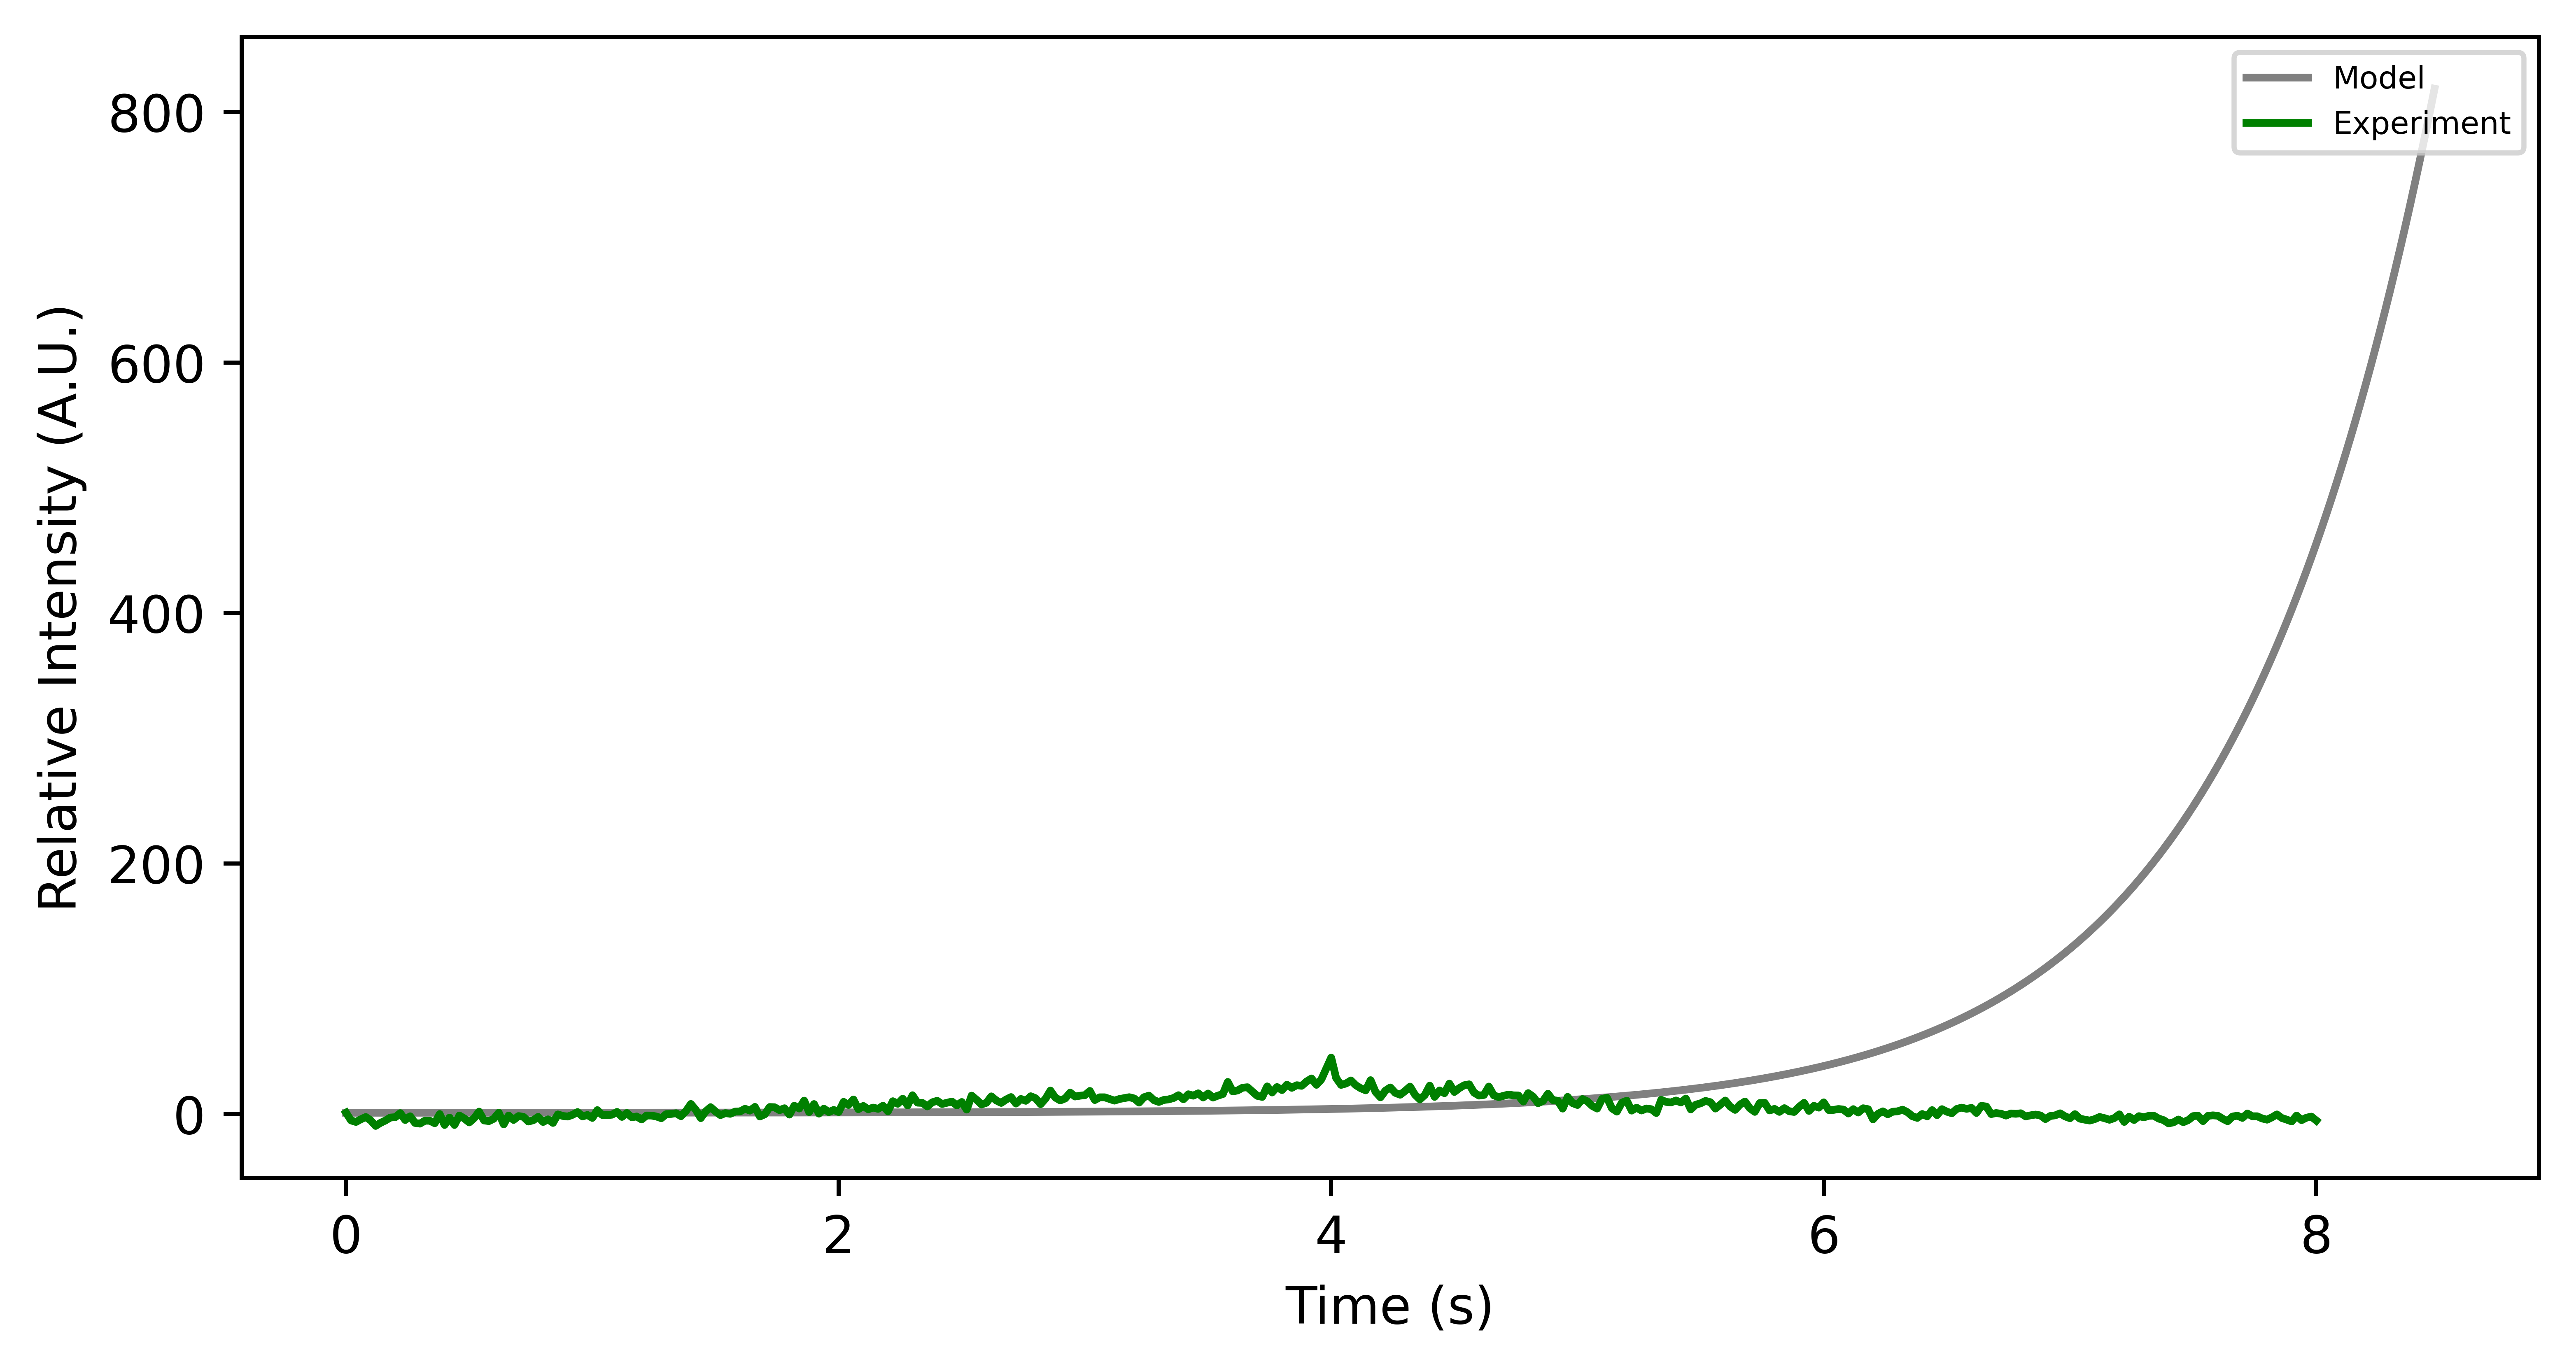

done with all 4 generations for Dsol 100
Modeling isoform: AB
AB isoform is GOINGGGGGG!
delIntensity HAS A VALUE OF: 1933.0938181818185
Data loaded correctly
Current generation
0


/Users/cmdb/mambaforge/envs/ODE_solver_JOHNSON/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/cmdb/mambaforge/envs/ODE_solver_JOHNSON/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


[0.11262459020592078, 189.4557289305307, 0.0879852448679443, 0.351155131456156, 0.010727006239472776, 0.0006094027933446971, 0.00831729733197441, 0.0004439408388764205, 1]
Current generation
1
[0.05772711085088285, 1.1362870854705005, 0.01, 0.15513828058085452, 0.0020936816359297295, 0.007927247379819114, 0.03541116437783004, 0.002594434188359206, 0.20590032732336128]
Current generation
2
[0.06207536383090619, 1.1362870854705005, 0.01, 0.15513828058085452, 0.0001, 0.06084073555716564, 0.00959178796820613, 0.003225981810902823, 0.01123115464867939]
Current generation
3


KeyboardInterrupt: 

In [267]:
popSize=4000
nGen = 4
nSamples = 2e3
Dmem0=10 # copies/um2
Dsol0=10
#testValues=np.array([10, 5, 1, 0.5])
GTPtestValues=np.array([50,100,150,200,250])
isoform='AB'
N=len(GTPtestValues)
for i in range(N):
    #Dsol0=testValues[i]
    GTPconc=GTPtestValues[i]
    model = Oscillator(parameter_ranges, paramsToOpt, Dsol0, Dmem0, GTPconc, isoform, mode=0) 
    solver = Solver(model, popSize, nGen, nSamples)         
    #estimate the initial viable set 
    [viablePoints, viableFitness, twoDVals] = solver.findNominalValues()
    #print("viableFitness[0][0]: "+ str(viableFitness[0][0]))
    #print("viablePoints[0]: "+ str(viablePoints[0]))
    solver.write_sortedParms(viablePoints, viableFitness, twoDVals,str(GTPconc))
    #solver.write_sortedParms(viablePoints, viableFitness, twoDVals,str(Dsol0))
    #print("wrote to file")
    print("done with all " + str(nGen)+ " generations for GTPconc "+str(GTPconc))
    #print("done with all " + str(nGen)+ " generations for Dsol "+str(Dsol0))
    